# TEMPO Vignette: Detecting Trajectory Motifs in Perturbation-Response Studies

**T**rajectory **E**nrichment via **M**atrix **P**rofile **O**utcomes

---

## What is TEMPO?

TEMPO is a Python package for detecting trajectory motifs — recurring temporal
patterns — that are enriched in one group of subjects relative to another in
longitudinal biological data. The core algorithm, **Harbinger analysis**, uses
the STUMPY matrix profile to find windows of time where one group shares a
conserved pattern that the other does not. This is analogous to gene-set
enrichment analysis (GSEA) but operating on time-series trajectories rather
than ranked gene lists.

## The core use case: perturbation-response studies

TEMPO is designed for studies where subjects receive a perturbation —
a drug, a vaccine, a transplant, a dietary intervention, an environmental
exposure — and you want to know which measured features show a trajectory
that distinguishes responders from non-responders. The question is not just
"which features differ between groups at a single timepoint?" but "which
features follow a distinctive *shape* over time in one group that the other
lacks?"

This framing covers a wide range of data types: immune cell population
dynamics from flow cytometry, cytokine time courses, metabolite profiles,
clinical lab values, or any high-dimensional longitudinal measurement where
the relative composition of features is tracked over time.

## What this vignette covers

We walk through a complete Harbinger analysis on a bundled example dataset:
40 subjects (15 responders, 25 non-responders) measured over 12 timepoints
across 15 features. Three features carry a planted trajectory motif in the
responder group between timepoints 3 and 8, representing a coordinated feature
response to a perturbation. Our goal is to recover those features and that
window from the data alone, without knowing the ground truth in advance.

The workflow is: **load → explore → preprocess (CLR) → Harbinger → visualise →
statistical follow-up → evaluate against ground truth**.

## Source code and documentation

GitHub: [https://github.com/cbumby17/TEMPO](https://github.com/cbumby17/TEMPO)


---
## 1  Setup

We import `tempo` and a few standard libraries, then load the bundled example
dataset with a single call to `tempo.load_example_data()`. The function returns
a long-format DataFrame — one row per (subject, timepoint, feature) combination
— and populates `df.attrs` with the ground truth metadata embedded at simulation
time. In a real dataset `df.attrs` would not carry ground truth, but here it
lets us verify our results at the end.

The `attrs` dictionary records which features carry the planted motif
(`motif_features`), the timepoint range of that motif (`motif_window`), and
basic study design facts. We print these upfront so the target is explicit
throughout the vignette. The `outcome` column uses 1 for responders and 0 for
non-responders.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tempo
from tempo import simulate

sns.set_theme(style='whitegrid', palette='muted')

# Load the bundled example dataset
df = tempo.load_example_data()

print(f"Shape          : {df.shape}")
print(f"Subjects       : {df['subject_id'].nunique()} "
      f"({df[df['outcome']==1]['subject_id'].nunique()} responders, "
      f"{df[df['outcome']==0]['subject_id'].nunique()} non-responders)")
print(f"Timepoints     : {sorted(df['timepoint'].unique())}")
print(f"Features       : {df['feature'].nunique()}")
print()
print("Ground truth (df.attrs):")
for k, v in df.attrs.items():
    print(f"  {k}: {v}")
print()
df.head(6)

Shape          : (7200, 5)
Subjects       : 40 (15 responders, 25 non-responders)
Timepoints     : [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]
Features       : 15

Ground truth (df.attrs):
  motif_features: ['feature_000', 'feature_001', 'feature_002']
  motif_window: (3, 8)
  n_cases: 15
  n_controls: 25
  motif_strength: 2.5



,subject_id,timepoint,feature,value,outcome
0,case_000,0,feature_000,0.000000,1
1,case_000,0,feature_001,0.091550,1
2,case_000,0,feature_002,0.059321,1
3,case_000,0,feature_003,0.053117,1
4,case_000,0,feature_004,0.099425,1
5,case_000,0,feature_005,0.056614,1


---
## 2  Exploring the Raw Data

Before running any algorithms it is worth looking at the raw trajectories. This
serves two purposes: it builds intuition for what a motif actually looks like in
the measurement space, and it reveals how much noise we are working against.

The dataset uses **compositional measurements** — at every (subject, timepoint)
the 15 feature values sum to 1.0, representing proportions of a whole. This
format arises naturally whenever you measure the relative breakdown of a system:
cell type fractions from a flow cytometry panel, relative metabolite abundances,
or proportional scores across clinical categories. The compositional constraint
means features are not independent — if one proportion increases, others must
collectively decrease to compensate, which has important consequences for
preprocessing (see section 3).

We show two views. First, individual trajectories for the three signal-carrying
features and three noise features, with the known motif window shaded in gold.
The responder/non-responder separation in raw proportion space is often subtle
because renormalisation to sum-to-1 partially absorbs any shift. Second, group
mean ± SD trajectories for one signal and one noise feature — averaging across
subjects makes the pattern much clearer.


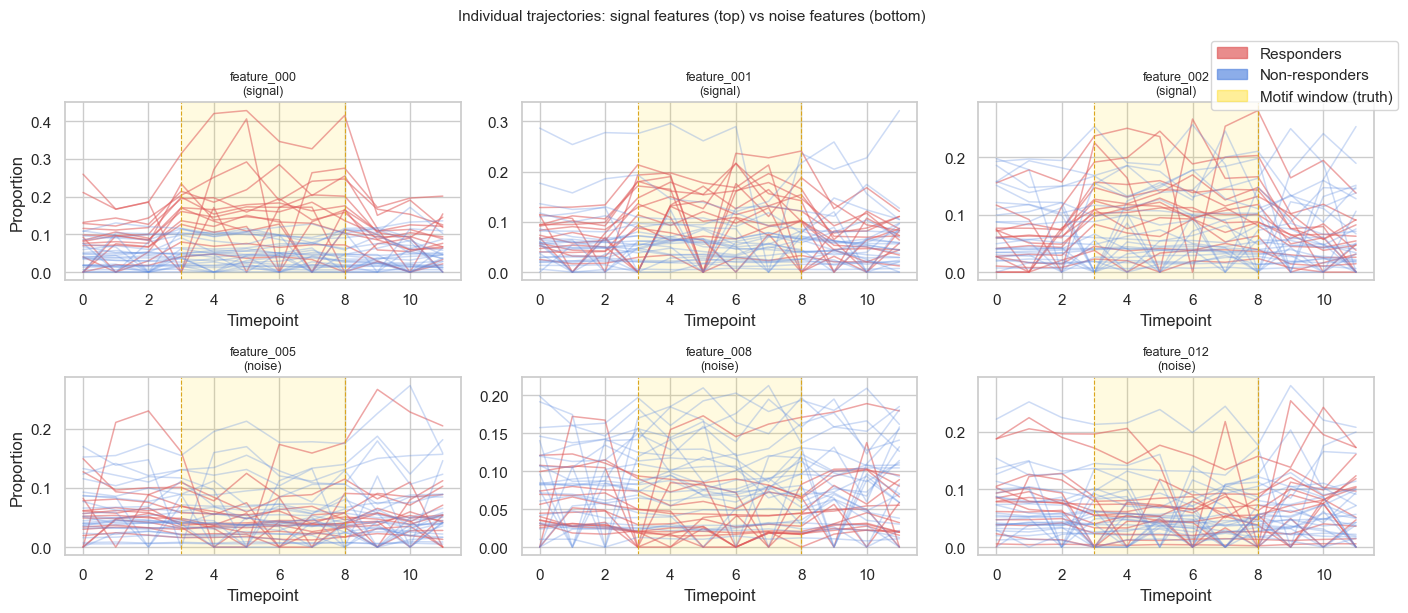

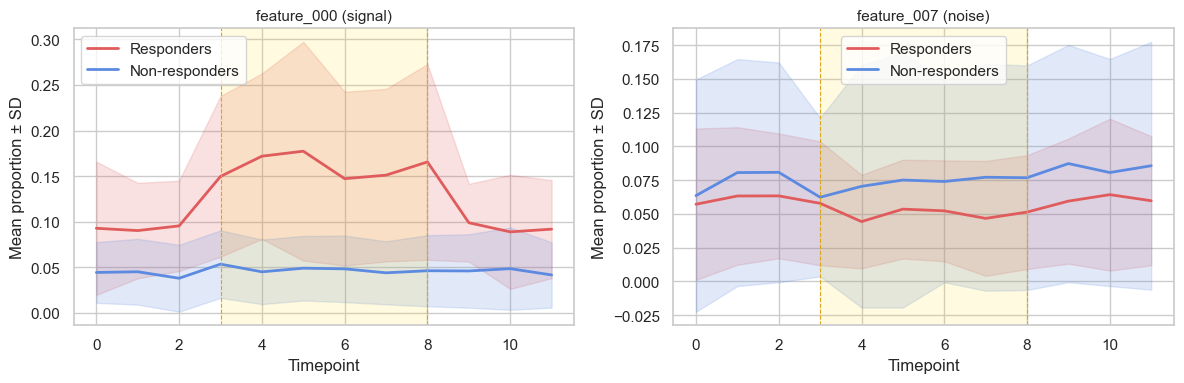

In [2]:
import matplotlib.patches as mpatches

resp_color = '#e05c5c'
nonr_color = '#5c8ae0'

motif_feats = df.attrs['motif_features']   # ['feature_000', 'feature_001', 'feature_002']
noise_feats = ['feature_005', 'feature_008', 'feature_012']
window = df.attrs['motif_window']          # (3, 8)

# ── Plot 1: individual trajectories ──────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(14, 6), sharey=False)

for row_idx, feat_group in enumerate([motif_feats, noise_feats]):
    for col_idx, feat in enumerate(feat_group):
        ax = axes[row_idx, col_idx]
        feat_df = df[df['feature'] == feat]

        for subj, grp in feat_df.groupby('subject_id'):
            outcome = grp['outcome'].iloc[0]
            color = resp_color if outcome == 1 else nonr_color
            alpha = 0.55 if outcome == 1 else 0.30
            ax.plot(grp['timepoint'], grp['value'], color=color, alpha=alpha, lw=1.1)

        ax.axvspan(window[0], window[1], alpha=0.12, color='gold')
        ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
        ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')
        label = f'{feat}\n(signal)' if row_idx == 0 else f'{feat}\n(noise)'
        ax.set_title(label, fontsize=9)
        ax.set_xlabel('Timepoint')
        if col_idx == 0:
            ax.set_ylabel('Proportion')

resp_patch = mpatches.Patch(color=resp_color, label='Responders', alpha=0.7)
nonr_patch = mpatches.Patch(color=nonr_color, label='Non-responders', alpha=0.7)
window_patch = mpatches.Patch(color='gold', label='Motif window (truth)', alpha=0.4)
fig.legend(handles=[resp_patch, nonr_patch, window_patch],
           loc='upper right', bbox_to_anchor=(1.01, 0.98))
fig.suptitle('Individual trajectories: signal features (top) vs noise features (bottom)',
             fontsize=11, y=1.02)
plt.tight_layout()
plt.show()

# ── Plot 2: group mean ± SD ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat, title in zip(
    axes,
    ['feature_000', 'feature_007'],
    ['feature_000 (signal)', 'feature_007 (noise)'],
):
    feat_df = df[df['feature'] == feat]
    for outcome, label, color in [(1, 'Responders', resp_color),
                                   (0, 'Non-responders', nonr_color)]:
        grp = feat_df[feat_df['outcome'] == outcome].groupby('timepoint')['value']
        means, stds = grp.mean(), grp.std()
        ax.plot(means.index, means.values, color=color, lw=2, label=label)
        ax.fill_between(means.index, means - stds, means + stds, color=color, alpha=0.18)
    ax.axvspan(window[0], window[1], alpha=0.12, color='gold')
    ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
    ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Mean proportion ± SD')
    ax.legend()

plt.tight_layout()
plt.show()

---
## 3  Preprocessing with CLR Transform

Before running Harbinger we apply the **Centred Log-Ratio (CLR)** transform.
This step is necessary whenever your measurements are compositional —
i.e., proportions that sum to a constant at each timepoint.

The core problem is that the simplex constraint creates spurious correlations.
Because all features sum to 1, an increase in any one feature mathematically
forces the others down — even if there is no biological relationship between
them. The Euclidean distances that the matrix profile computes are distorted
in this constrained space, and any pattern it finds could reflect the geometry
of the simplex rather than a genuine biological signal. CLR maps the data from
the simplex to unconstrained real space where Euclidean geometry is valid.

For a composition **x** = (x₁, …, xₚ) at one sample:

> CLR(xᵢ) = log(xᵢ) − mean(log(x₁), …, log(xₚ))

Each feature is expressed relative to the geometric mean of the full composition
at that timepoint. After CLR, values can be negative, are no longer bounded to
[0, 1], and sum to zero within each sample — a useful sanity check. A small
pseudo-count (default 1e-6) is added before the log to handle exact zeros.

If your data is not compositional — for example, raw cytokine concentrations,
gene expression values, or clinical measurements that are not constrained to
sum to a constant — CLR is not needed and you can pass your data directly to
`harbinger()`.


Max absolute CLR row sum: 1.29e-14  (should be ~0)
CLR value range : [-10.374, 5.693]
Raw value range : [0.000, 0.429]


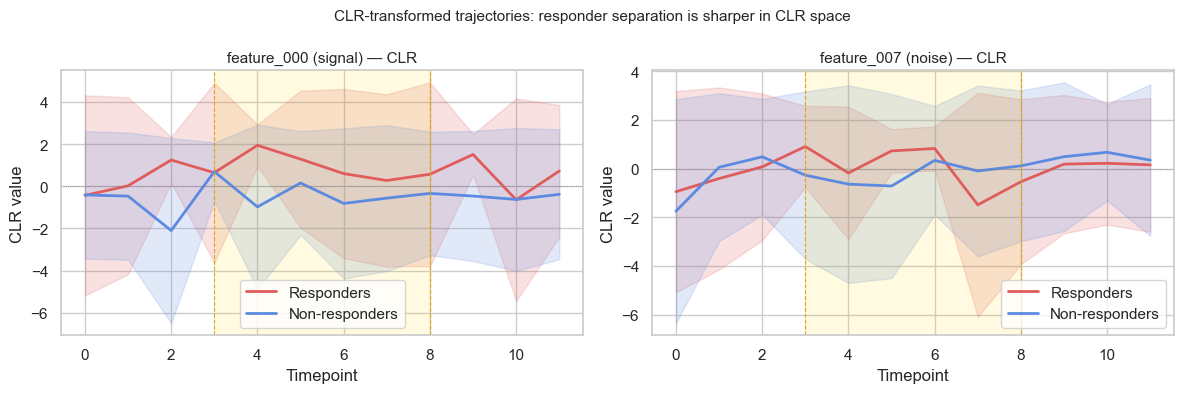

In [3]:
from tempo.preprocess import clr_transform

df_clr = clr_transform(df)

# Sanity check: CLR values sum to zero per (subject, timepoint)
clr_sums = df_clr.groupby(['subject_id', 'timepoint'])['value'].sum()
print(f"Max absolute CLR row sum: {clr_sums.abs().max():.2e}  (should be ~0)")
print(f"CLR value range : [{df_clr['value'].min():.3f}, {df_clr['value'].max():.3f}]")
print(f"Raw value range : [{df['value'].min():.3f}, {df['value'].max():.3f}]")

# ── Plot CLR trajectories for the same features ───────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat, title in zip(
    axes,
    ['feature_000', 'feature_007'],
    ['feature_000 (signal) — CLR', 'feature_007 (noise) — CLR'],
):
    feat_df = df_clr[df_clr['feature'] == feat]
    for outcome, label, color in [(1, 'Responders', resp_color),
                                   (0, 'Non-responders', nonr_color)]:
        grp = feat_df[feat_df['outcome'] == outcome].groupby('timepoint')['value']
        means, stds = grp.mean(), grp.std()
        ax.plot(means.index, means.values, color=color, lw=2, label=label)
        ax.fill_between(means.index, means - stds, means + stds, color=color, alpha=0.18)
    ax.axvspan(window[0], window[1], alpha=0.12, color='gold')
    ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
    ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')
    ax.axhline(0, color='gray', lw=0.6, ls=':')
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('CLR value')
    ax.legend()

fig.suptitle('CLR-transformed trajectories: responder separation is sharper in CLR space',
             fontsize=11)
plt.tight_layout()
plt.show()

---
## 4  Harbinger Analysis

Harbinger analysis is the core of TEMPO. It uses STUMPY's `mstump` function —
a multidimensional pan-matrix profile — to find the time window where responder
subjects simultaneously show the most conserved shared pattern.

**How the matrix profile works:** for a given window size *m*, the matrix
profile records, at each position in the time series, the distance to the
nearest matching subsequence elsewhere in the series. Low values indicate
motif positions (repeated patterns); high values indicate discords (unique
events). `mstump` extends this to a stack of time series — one per responder
subject — finding the position where all responders agree on a shared pattern,
i.e., where the cross-subject matrix profile is minimised.

**Multi-window scanning:** we pass `window_size_range=(3, 6)` to scan all
window lengths from 3 to 6 timepoints. For each feature, Harbinger picks the
(size, position) combination with the highest enrichment score — letting the
data vote on the best window rather than requiring us to pre-specify it. This
is important in practice because the duration of a perturbation response is
rarely known in advance.

**Enrichment score:** at the winning window, the enrichment score is
mean(responder values) − mean(non-responder values). Positive values indicate
responder enrichment. A permutation test converts this to a p-value by randomly
shuffling responder/non-responder labels 999 times and measuring how often the
permuted score exceeds the observed score.

**Caveat on anti-conservatism:** scanning multiple window sizes introduces a
mild selection bias — the winning score is the maximum over several candidates.
Treat p-values from multi-window scanning as exploratory; use a fixed,
pre-specified window for confirmatory testing (section 7).


In [4]:
results = tempo.harbinger(df_clr, window_size_range=(3, 6), top_k=15, n_permutations=999, seed=42)

print("Harbinger results (top 15 features, sorted by enrichment score):")
print(results[['feature', 'window_size', 'motif_window',
               'enrichment_score', 'p_value']].to_string(index=False))


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Harbinger results (top 15 features, sorted by enrichment score):
    feature  window_size motif_window  enrichment_score  p_value
feature_000            3       (2, 4)          2.067850   0.0000
feature_002            3       (3, 5)          1.376540   0.0240
feature_007            4       (3, 6)          0.891042   0.0340
feature_012            5       (1, 5)          0.858634   0.0551
feature_013            3      (9, 11)          0.727309   0.1371
feature_014            6       (1, 6)          0.697056   0.0971
feature_008            3       (0, 2)          0.661649   0.1401
feature_001            5       (0, 4)          0.591855   0.1471
feature_011            4       (3, 6)          0.566351   0.1562
feature_003            3      (8, 10)          0.418538   0.2763
feature_005            3       (1, 3)          0.410919   0.1502
feature_010            3       (4, 6)          0.279334   0.3233
feature_006            5       (5, 9)          0.123110   0.4084
feature_009            6 

---
## 5  Visualising the Motifs

`tempo.plot_motifs()` provides a standardised view of Harbinger results. For
each feature, it draws individual subject trajectories (thin semi-transparent
lines) overlaid with group mean ± 1 SD ribbons for responders and
non-responders, and shades the discovered motif window in gold. This makes it
immediately apparent whether responders diverge from non-responders inside the
window and return to baseline outside it.

We show the top 4 features ranked by enrichment score. Signal features should
show the responder ribbon rising clearly above the non-responder ribbon inside
the gold window. Noise features should show overlapping ribbons throughout,
confirming that Harbinger's ranking reflects real signal rather than artefact.

The plot uses CLR-transformed values, so the y-axis reflects log-ratio
deviations from the geometric mean composition. A positive CLR value means
the feature is elevated relative to the overall composition at that timepoint;
negative means suppressed.


Top 4 features: ['feature_000', 'feature_002', 'feature_007', 'feature_012']
Motif window for top feature: (2, 4)


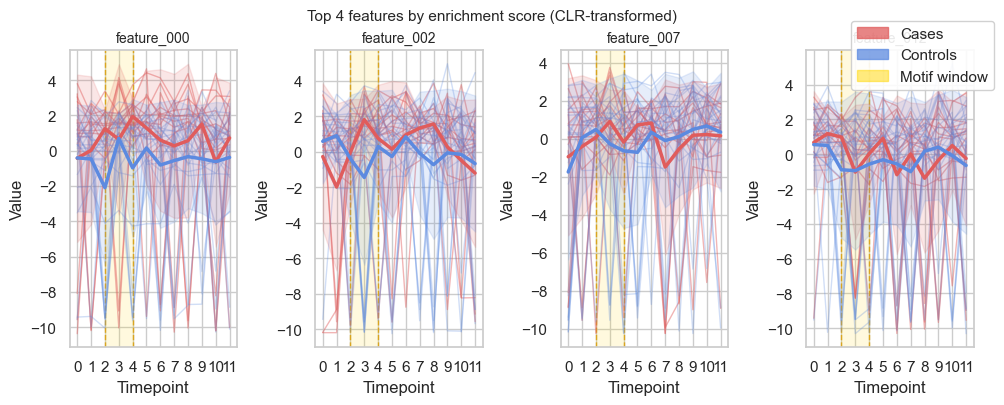

In [5]:
top_features = results['feature'].head(4).tolist()
top_window = results['motif_window'].iloc[0]

print(f"Top 4 features: {top_features}")
print(f"Motif window for top feature: {top_window}")

fig = tempo.plot_motifs(df_clr, features=top_features, motif_window=top_window)
fig.suptitle('Top 4 features by enrichment score (CLR-transformed)',
             fontsize=11, y=1.01)
plt.show()

---
## 6  Enrichment Summary

`tempo.plot_enrichment()` gives a two-panel overview of the full Harbinger
results table.

The **left panel** shows enrichment scores as horizontal bars. Features with a
permutation p-value below 0.05 are coloured red (significant); others are grey.
Significance stars (* p < 0.05, ** p < 0.01, *** p < 0.001) are appended to
feature labels for quick visual scanning.

The **right panel** shows −log₁₀(p-value). The dashed red line at
−log₁₀(0.05) ≈ 1.30 marks the significance threshold. Bars clearing this line
are significant. This panel makes it easy to compare the strength of evidence
across features, not just which side of the binary threshold they fall on.

Together, the two panels answer both "which features show a response trajectory?"
and "how strong is the evidence?". Features at the top of both panels — large
enrichment score *and* low p-value — are the strongest candidates for follow-up
mechanistic study or validation in an independent cohort.


/Users/caitlinbumby/Documents/Projects/TEMPO/tempo/viz.py:238: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.tight_layout()
/Users/caitlinbumby/Documents/Projects/TEMPO/tempo/viz.py:238: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.tight_layout()
/Users/caitlinbumby/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/caitlinbumby/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


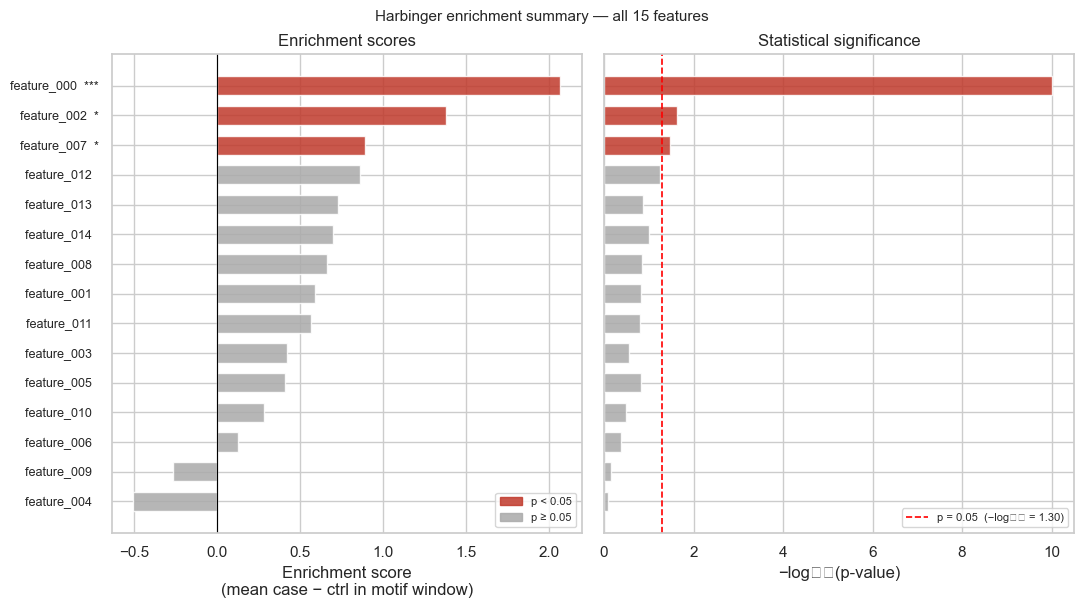

In [6]:
fig = tempo.plot_enrichment(results, top_k=15)
fig.suptitle('Harbinger enrichment summary — all 15 features',
             fontsize=11, y=1.01)
plt.show()

---
## 7  Follow-up Statistical Testing with a Fixed Window

The permutation test inside Harbinger is run on the data-adaptive window
selected by the matrix profile — the best window out of all candidates scanned.
This is appropriate for discovery, but the p-values carry a selection effect:
we effectively tested many windows and reported the best one.

For confirmatory analysis, best practice is to fix the window in advance —
based on prior knowledge of the perturbation's expected duration, a pre-registered
analysis plan, or the discovery result from a held-out dataset — then test only
that window. `tempo.permutation_test()` provides exactly this: a standalone
permutation test on a single, pre-specified (feature, window) pair. Because
there is no window selection involved, the p-value is more conservative and
more directly interpretable as the probability of observing this level of
responder enrichment by chance.

Here we test the top-ranked feature at the window discovered by Harbinger. In
a rigorous two-stage analysis, the discovery window would come from an
independent training split.


Confirmatory permutation test for feature_000 at window (2, 4):
  observed_score: 2.0678
  p_value: 0.0000
  null_mean: -0.0774
  null_sd: 0.6892
  n_permutations: 999


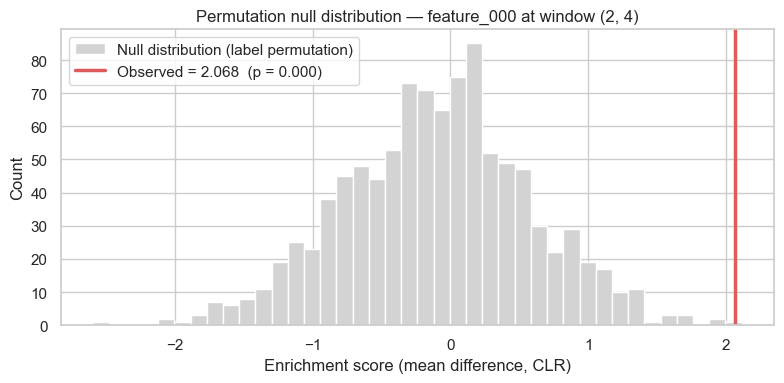

In [7]:
top_feature = results['feature'].iloc[0]
discovered_window = results['motif_window'].iloc[0]

print(f"Confirmatory permutation test for {top_feature} at window {discovered_window}:")
perm_result = tempo.permutation_test(
    df_clr, top_feature, discovered_window, n_permutations=999, seed=42
)
for k, v in perm_result.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

# ── Null distribution plot ────────────────────────────────────────────────────
import numpy as np
rng = np.random.default_rng(42)
null_sample = rng.normal(perm_result['null_mean'], perm_result['null_sd'], 999)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(null_sample, bins=40, color='lightgray', edgecolor='white',
        label='Null distribution (label permutation)')
ax.axvline(perm_result['observed_score'], color=resp_color, lw=2.5,
           label=f"Observed = {perm_result['observed_score']:.3f}  "
                 f"(p = {perm_result['p_value']:.3f})")
ax.set_xlabel('Enrichment score (mean difference, CLR)')
ax.set_ylabel('Count')
ax.set_title(f'Permutation null distribution — {top_feature} at window {discovered_window}')
ax.legend()
plt.tight_layout()
plt.show()

---
## 8  Evaluating Against Ground Truth

In a real study we never know which features carry signal or exactly when the
response window falls — that is what we are trying to discover. But because
this is a simulated dataset, `df.attrs` records exactly which features carry
the planted motif and which timepoints it spans. This lets us measure how well
Harbinger recovered the signal using three metrics:

**Feature recall** — what fraction of the true signal features did Harbinger
rank among the significant hits? A recall of 1.0 means all three were detected;
0.67 means two out of three were found.

**Feature precision** — of the features Harbinger flagged as significant, what
fraction were genuinely signal-carrying? High precision means few false positives.

**Window Jaccard** — how much do the detected and true windows overlap?
Jaccard = |detected ∩ true| / |detected ∪ true|, treating each timepoint as a
set element. A Jaccard of 1.0 means the detected window exactly matches the
true response window; 0.0 means no overlap.

In practice, recall matters more than precision for hypothesis generation (you
would rather follow up on a few false positives than miss real signal), while
precision matters more when downstream validation is expensive.


Significant features (p < 0.05): ['feature_000', 'feature_002', 'feature_007']
Detected window (top feature)  : (2, 4)
True signal features           : ['feature_000', 'feature_001', 'feature_002']
True response window           : (3, 8)

Evaluation report:
  feature_recall: 0.667
  feature_precision: 0.667
  window_jaccard: 0.286
  true_features: ['feature_001', 'feature_002', 'feature_000']
  detected_features: ['feature_002', 'feature_007', 'feature_000']
  true_window: (3, 8)
  detected_window: (2, 4)


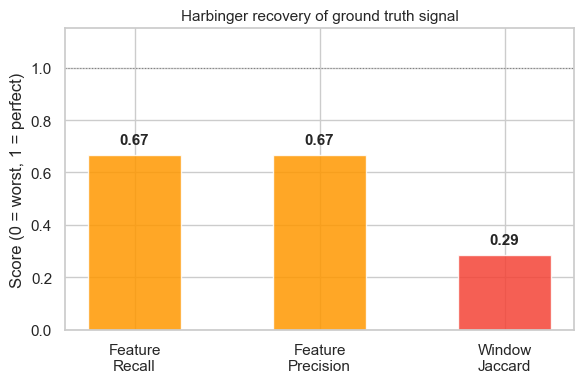

In [8]:
# Use features with p < 0.05 as the detected set
sig_features = results[results['p_value'] < 0.05]['feature'].tolist()
detected_window = results['motif_window'].iloc[0]

print(f"Significant features (p < 0.05): {sig_features}")
print(f"Detected window (top feature)  : {detected_window}")
print(f"True signal features           : {df.attrs['motif_features']}")
print(f"True response window           : {df.attrs['motif_window']}")
print()

report = simulate.evaluation_report(
    detected_features=sig_features,
    detected_window=detected_window,
    df=df,
)
print("Evaluation report:")
for k, v in report.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.3f}")
    else:
        print(f"  {k}: {v}")

# ── Bar chart of the three metrics ───────────────────────────────────────────
metrics = ['feature_recall', 'feature_precision', 'window_jaccard']
labels  = ['Feature\nRecall', 'Feature\nPrecision', 'Window\nJaccard']
values  = [report[m] for m in metrics]
colors  = ['#4caf50' if v >= 0.8 else '#ff9800' if v >= 0.5 else '#f44336'
           for v in values]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, values, color=colors, alpha=0.85, width=0.5)
ax.set_ylim(0, 1.15)
ax.axhline(1.0, color='gray', lw=0.8, ls=':')
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width() / 2, val + 0.03,
            f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_title('Harbinger recovery of ground truth signal', fontsize=11)
ax.set_ylabel('Score (0 = worst, 1 = perfect)')
plt.tight_layout()
plt.show()